# Mapping of Water Quality Sites
------------

## Introduction

### Overview

This Notebook provides some examples of combining mapping, and quantitative data display in a single graphic.  The main packages used as Folium and Altair.

### Motivation

One of my activities is to regularly take water quality measurements  (as part of https://ecollaboration.org.au/community-engagement/maroochy-waterwatch/).  I thought it might be interesting to display some of the data collected in a spatial context (i.e. on a map).

### Disclaimer

The cells holding Folium maps in this Notebook do not display in Microsoft Edge.  I have included image displays where needed, to show the graphic results.  Chrome seems to work fine.

--------------
## Implementation

### Notebook Imports

In [2]:
# all imports should go here

import pandas as pd
import numpy
import folium
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display

import altair as alt



import sys
import os
import subprocess
import datetime
import platform
import datetime

### Notebook magic commands

```watermark``` provides documentation of the Python environment.

```lab_black``` formats the Python cells

In [3]:
%matplotlib inline

In [4]:
%load_ext watermark

In [5]:
%load_ext lab_black

### Customizations for notebook

In [6]:
# path to saved figures
DATA_PREFIX = '../data/'

### Supporting Functions

None

----------------------
## Data Load

To start with, we load a database of water quality site locations, and perform some data exploration.

In [7]:
site_data_path = DATA_PREFIX + 'Cleaned Site Details.xlsx'
site_df = pd.read_excel(site_data_path)

In [8]:
site_df.head()

,Waterway,Site Code,Site Name,Water Body Type,latitude,longitude
0,Cornmeal Creek,CRN700,"Duporth Ave Bridge, Maroochydore",Enclosed Coastal/Lower estuary,-26.697250,152.980694
1,Cornmeal Creek,CRN800,"Horton Parade Bridge, Maroochydore",Middle Estuary,-26.653564,153.090566
2,Cornmeal Creek,CRN900,"Duporth Ave Bridge, Maroochydore",Middle Estuary,-26.655556,153.087806
3,Paynter Creek,DUC100,"Duck Ponds (Kolora Park), Palmwoods",Lake / Lowland Freshwater,-26.685389,152.959944
4,South Maroochy River,ECH700,"Sherwell Road (Savage Property), Dulong",Lowland Freshwater,-26.626778,152.882611


We get the unique names of the waterways, and create a dict that will map waterway name to a unique index.

In [9]:
waterways = pd.unique(site_df['Waterway'])

waterway_i = {n: i for i, n in enumerate(waterways)}

How many waterways do we have?

In [10]:
len(waterways)

10

We create colourmap for waterways.  ```tab10``` is a colormap for qualititive data, and by a happy coincidence, has as many colors as we have waterways.

In [11]:
cmap = plt.cm.get_cmap('tab10', len(waterways))

-----------
 ## Mapping
 
 ### Supporting Mapping Functions

We now define a function that takes the pandas dataframe holding site details, including latitude and longitude, and creates markers. Each site gets a marker that is color coded for the waterway.  In order to be able to turn the site locations on/off in our map display, we create a FeatureGroup, and add markers to that.  We then add the FeatureGroup to Folium map.

In [12]:
def add_site_markers(
    folium_map: folium.Map,
    cmap: matplotlib.colors.ListedColormap,
    site_df: pd.core.frame.DataFrame,
    waterway_i: dict,
) -> None:
    '''
    add_site_markers: add markers for water quality sites to folium map
    
    Parameters:
    folium_map: folium.Map to add markers to
    cmap: colormap for waterway identification
    site_df: pandas dataframe hold water quality site locations
    waterway_i:  dictionary giving index into waterway names from waterway name
    
    Side Effects
    folium_map update with markers
    
    Return:
    site_fg: Folium Feature Group being added
   
    '''

    SITE_MARKER_SIZE = 5
    SITE_MARKER_FILL_OPACITY = 0.95

    #  get arrays of data to be used to build markers
    lng = site_df['longitude']
    lat = site_df['latitude']

    site_code = site_df['Site Code']
    site_name = site_df['Site Name']

    waterway = site_df['Waterway']

    # create a FeatureGroup so Sites can be turned off
    site_fg = folium.FeatureGroup(
        name='Water Quality Sites', show=True
    )

    # for each  site, add marker to layer
    # marker is translucent so zoom out will look ok

    for (
        marker_y,
        marker_x,
        marker_site_code,
        marker_site_name,
        marker_way,
    ) in zip(lat, lng, site_code, site_name, waterway):

        # get R, G, B elements of color for this waterway
        # by looking up index of waterway from name
        # and using that index to get r,g,b from color map
        # alpha value ignored

        # get r, g. b, as 0.0<->1.0
        r, g, b, __ = cmap(waterway_i[marker_way])
        # get r, g, b as 0<->255
        r, g, b = (int(r * 256), int(g * 256), int(b * 256))

        # get Leaflet style color string (hex values for r, g, b)
        # two hex digits right justified, zero filled
        marker_color_string = f'#{r:0>2x}{g:0>2x}{b:0>2x}'

        circ_mkr = folium.CircleMarker(
            location=[marker_y, marker_x],
            radius=SITE_MARKER_SIZE,
            color=marker_color_string,
            fill=True,
            fill_color=marker_color_string,
            fillOpacity=SITE_MARKER_FILL_OPACITY,
            opacity=SITE_MARKER_FILL_OPACITY,
            tooltip=f'{marker_site_code}',
            popup=marker_site_name,
        )
        circ_mkr.add_to(site_fg)
    # end for

    # add unclustered markers to map
    site_fg.add_to(folium_map)

    return site_fg


# end add_site_markers

We create a map, select two background layers (user selectable), create the site markers FeatureGroup and add it to the map.  We use the extent (bounds) of the FeatureGroup to zoom the map back to show all the site markers.

In [78]:
start_coords = [-26.52, 153.09]
folium_map = folium.Map(
    tiles=None,
    location=start_coords,
    zoom_start=13,
    width='80%',
    height='80%',
    control_scale=True,
)

# support two basemaps: Open Street Map will be the default
folium.TileLayer(
    tiles='OpenStreetMap', name='Open Street Map', show=True
).add_to(folium_map)
folium.TileLayer(
    tiles='Stamen Terrain', name='Terrain Map', show=False
).add_to(folium_map)


sites_fg = add_site_markers(
    folium_map, cmap, site_df, waterway_i
)
bounds = sites_fg.get_bounds()
folium_map.fit_bounds(bounds)

#  add a control to turn layers on / aff
folium.LayerControl().add_to(folium_map)

# add a title
title_html = '''
             <h3 align="left" style="font-size:20px"><b>ECOllaboration Water Quality Sites</b></h3>
             '''
folium_map.get_root().html.add_child(
    folium.Element(title_html)
)


display(folium_map)

The Layer Control looks like:

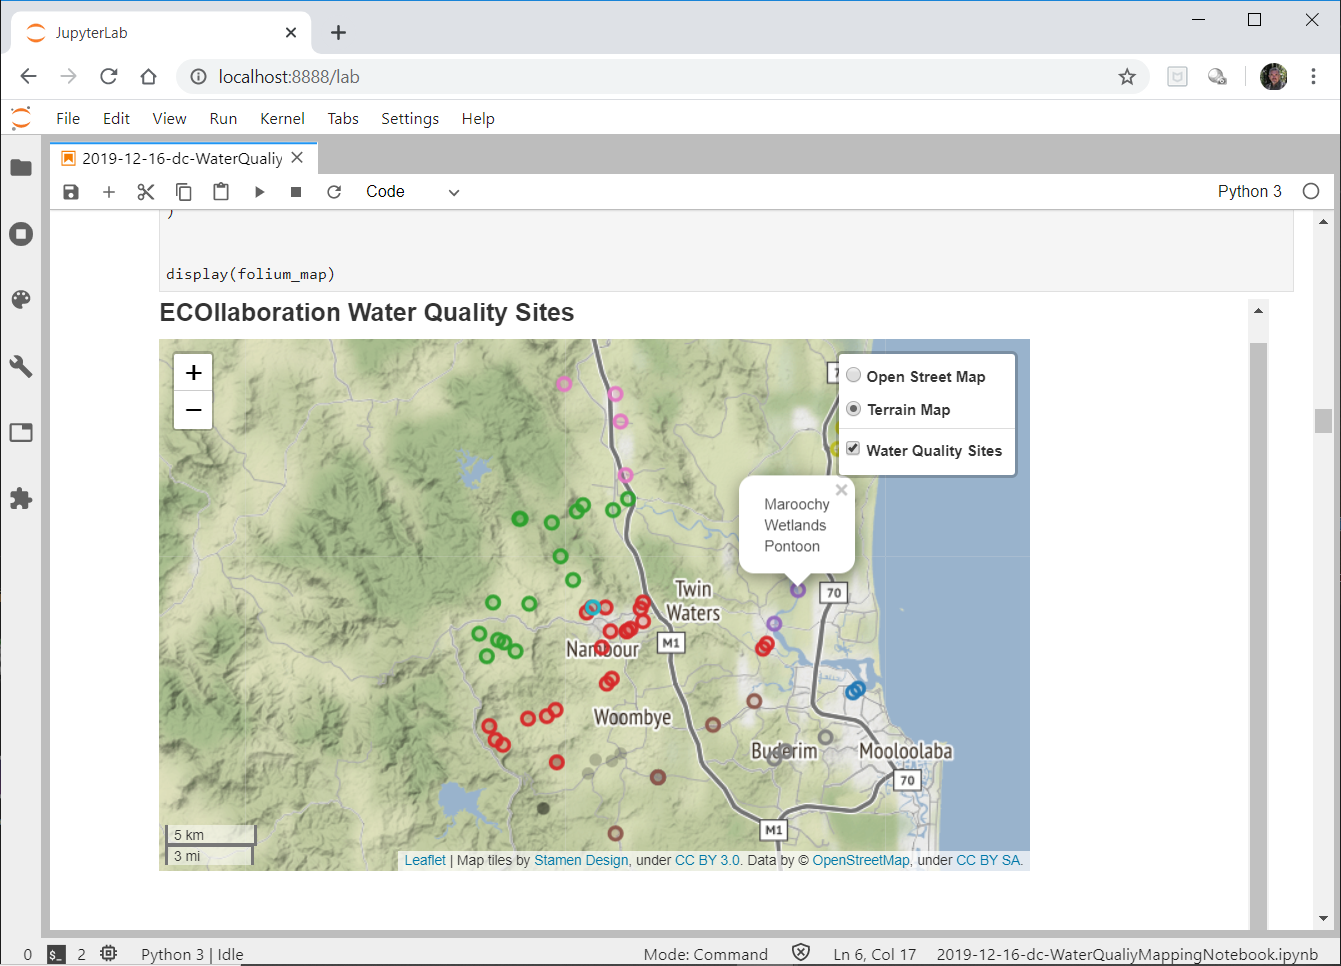

In [75]:
from IPython.display import Image

Image('../figures/folium01.png')

The previous map had one layer for all water quality sites.  As an experiment, we will create a layer (FeatureGroup) for each waterway.

In [20]:
def add_ww_markers(
    folium_map: folium.Map,
    cmap: matplotlib.colors.ListedColormap,
    site_df: pd.core.frame.DataFrame,
    waterway_i: dict,
    waterways: numpy.ndarray,
) -> None:
    '''
    add_ww_markers: add markers for water quality sites coded by waterway to folium map
    
    Parameters:
    folium_map: folium.Map to add markers to
    cmap: colormap for waterway identification
    site_df: pandas dataframe hold water quality site locations
    waterway_i:  dictionary giving index into waterway names from waterway name
    waterways: np.ndarray holding strings being waterway names
    
    Side Effects
    folium_map update with markers
    folium_map bounds set to show complete marker set
    
    Return:
    None
   
    '''

    SITE_MARKER_SIZE = 5
    SITE_MARKER_FILL_OPACITY = 0.95

    lng = site_df['longitude']
    lat = site_df['latitude']

    site_code = site_df['Site Code']
    site_name = site_df['Site Name']

    waterway = site_df['Waterway']

    # create a FeatureGroup for each waterway
    site_fgs = [
        folium.FeatureGroup(name=name, show=True)
        for name in waterways
    ]

    # for each  site, add marker to layer for that waterway
    is_first = True  # trigger initial map bounds processing
    for (
        marker_y,
        marker_x,
        marker_site_code,
        marker_site_name,
        marker_way,
    ) in zip(lat, lng, site_code, site_name, waterway):

        # get R, G, B elements of color for this waterway
        # by looking up index of waterway from name
        # and using that index to get r,g,b from color map
        # alpha value ignored

        # get r, g. b, as 0.0<->1.0
        r, g, b, __ = cmap(waterway_i[marker_way])
        # get r, g, b as 0<->255
        r, g, b = (int(r * 256), int(g * 256), int(b * 256))

        # get Leaflet style color string (hex values for r, g, b)
        # two hex digits right justified, zero filled
        marker_color_string = f'#{r:0>2x}{g:0>2x}{b:0>2x}'

        circ_mkr = folium.CircleMarker(
            location=[marker_y, marker_x],
            radius=SITE_MARKER_SIZE,
            color=marker_color_string,
            fill=True,
            fill_color=marker_color_string,
            fillOpacity=SITE_MARKER_FILL_OPACITY,
            opacity=SITE_MARKER_FILL_OPACITY,
            tooltip=f'{marker_site_code}',
            popup=marker_site_name,
        )
        # add marker to the waterway group the site belongs to
        #  update minimum and maximum map extents (bounds)
        circ_mkr.add_to(site_fgs[waterway_i[marker_way]])
        if is_first:
            is_first = False
            bounds = site_fgs[
                waterway_i[marker_way]
            ].get_bounds()
        else:
            new_bounds = site_fgs[
                waterway_i[marker_way]
            ].get_bounds()
            bounds = [
                [
                    min(bounds[0][0], new_bounds[0][0]),
                    min(bounds[0][1], new_bounds[0][1]),
                ],
                [
                    max(bounds[1][0], new_bounds[1][0]),
                    max(bounds[1][1], new_bounds[1][1]),
                ],
            ]
        # end if

    # end for

    # add  markers to map
    for i in range(len(waterways)):
        site_fgs[i].add_to(folium_map)
    # end for

    # set map extent at start
    folium_map.fit_bounds(bounds)

    return None


# end add_ww_markers

Now, we have a layer control with many options.

In [76]:
start_coords = [-26.52, 153.09]
folium_map = folium.Map(
    tiles=None,
    location=start_coords,
    zoom_start=13,
    width='90%',
    height='100%',
    control_scale=True,
)

# support two basemaps
folium.TileLayer(
    tiles='OpenStreetMap', name='Open Street Map', show=True
).add_to(folium_map)
folium.TileLayer(
    tiles='Stamen Terrain', name='Terrain Map', show=False
).add_to(folium_map)


add_ww_markers(
    folium_map, cmap, site_df, waterway_i, waterways
)
folium.LayerControl().add_to(folium_map)

title_html = '''
             <h3 align="left" style="font-size:20px"><b>ECOllaboration Water Quality Sites</b></h3>
             '''
folium_map.get_root().html.add_child(
    folium.Element(title_html)
)


display(folium_map)

The Layer Control now looks like as below.  I suspect that I pushed past some guideline for number of layers.  It would be nice to be able to color-code the LayerControl to match the Marker color, but I don't know how to do that (yet).

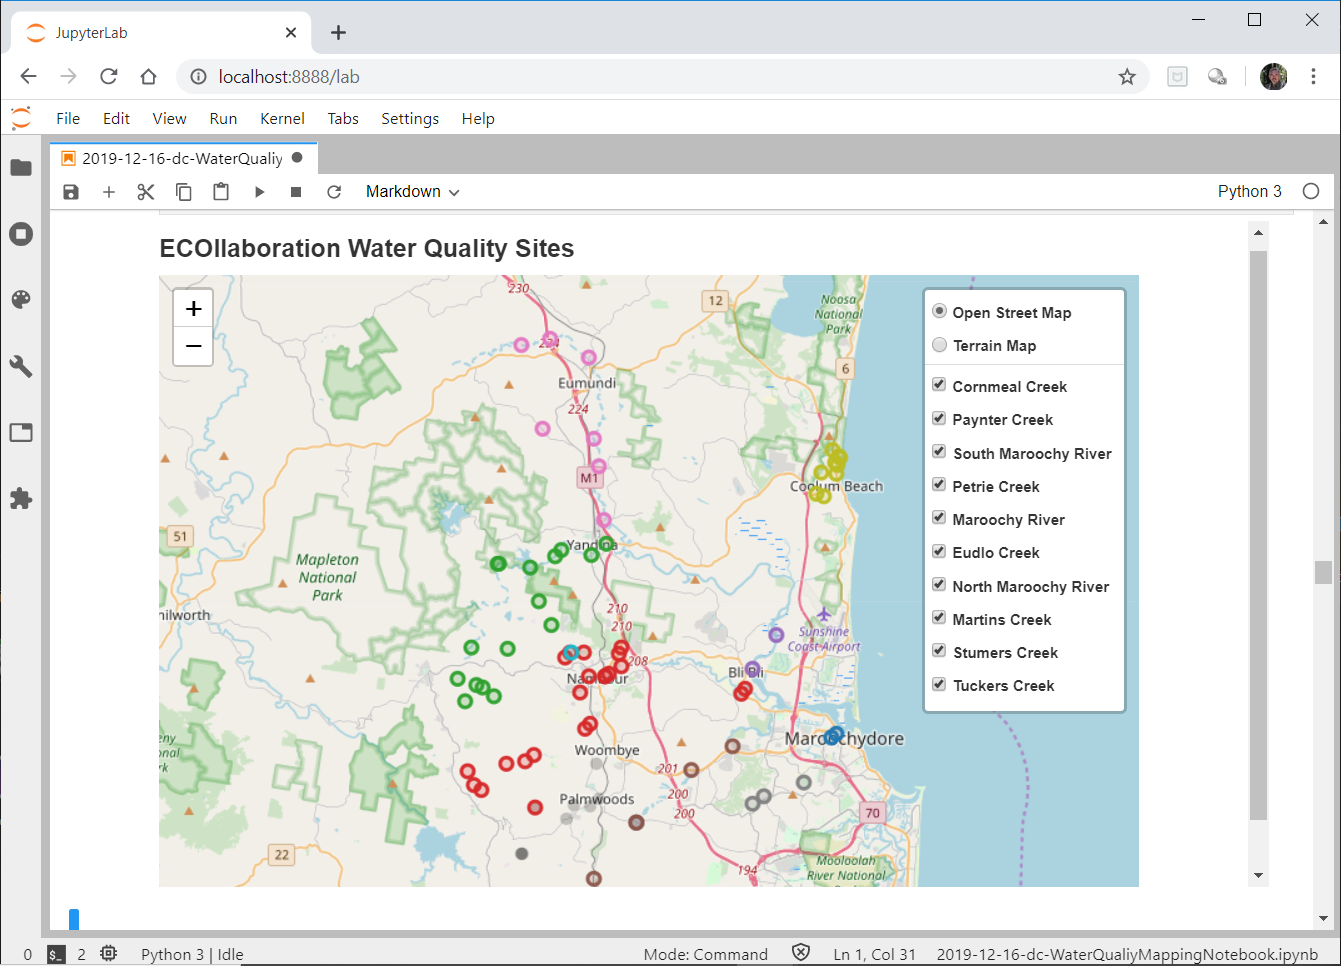

In [77]:
from IPython.display import Image

Image('../figures/folium02.png')

--------------
## Data visualization on a map

#### Altair Charts

Folium supports display of Altair charts, as a popup associated with a Folium marker.

We will build a simple example of an Altair Chart.

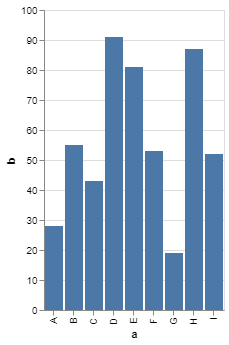

In [70]:
alt.renderers.enable('default')

source = pd.DataFrame(
    {
        'a': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'],
        'b': [28, 55, 43, 91, 81, 53, 19, 87, 52],
    }
)
# create a bar graph from data
alt.Chart(source).mark_bar().encode(x='a', y='b')

We now create a Chart that shows lines joining data points.  In Altair this is two charts, stacked by the ```+``` operator. 

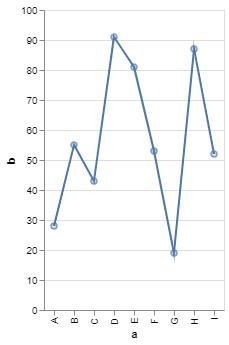

In [71]:
a = alt.Chart(source).mark_point().encode(x='a', y='b')

b = alt.Chart(source).mark_line().encode(x='a', y='b')

a + b

#### Charts in a Popup

As before we create a Folium map, and add a single marker to it.  This time, instead of text, we specify the JSON that results from JSON-ifying a Altair Chart.

In [81]:
start_coords = [-26.52, 153.09]
folium_map = folium.Map(
    tiles=None,
    location=start_coords,
    zoom_start=13,
    width='80%',
    height='80%',
    control_scale=True,
)

# support two basemaps
folium.TileLayer(
    tiles='OpenStreetMap', name='Open Street Map', show=True
).add_to(folium_map)
folium.TileLayer(
    tiles='Stamen Terrain', name='Terrain Map', show=False
).add_to(folium_map)

folium.LayerControl().add_to(folium_map)

my_chart = a + b
vis1 = my_chart.to_json()

circ_mkr = folium.CircleMarker(
    location=start_coords,
    radius=20,
    color='red',
    fill=True,
    fill_color='red',
    fillOpacity=1.0,
    opacity=1.0,
    tooltip='Altair Graph',
    popup=folium.Popup(max_width=400).add_child(
        folium.VegaLite(vis1, width=400, height=300)
    ),
)
circ_mkr.add_to(folium_map)

In [82]:
folium_map

The popup display now looks like.

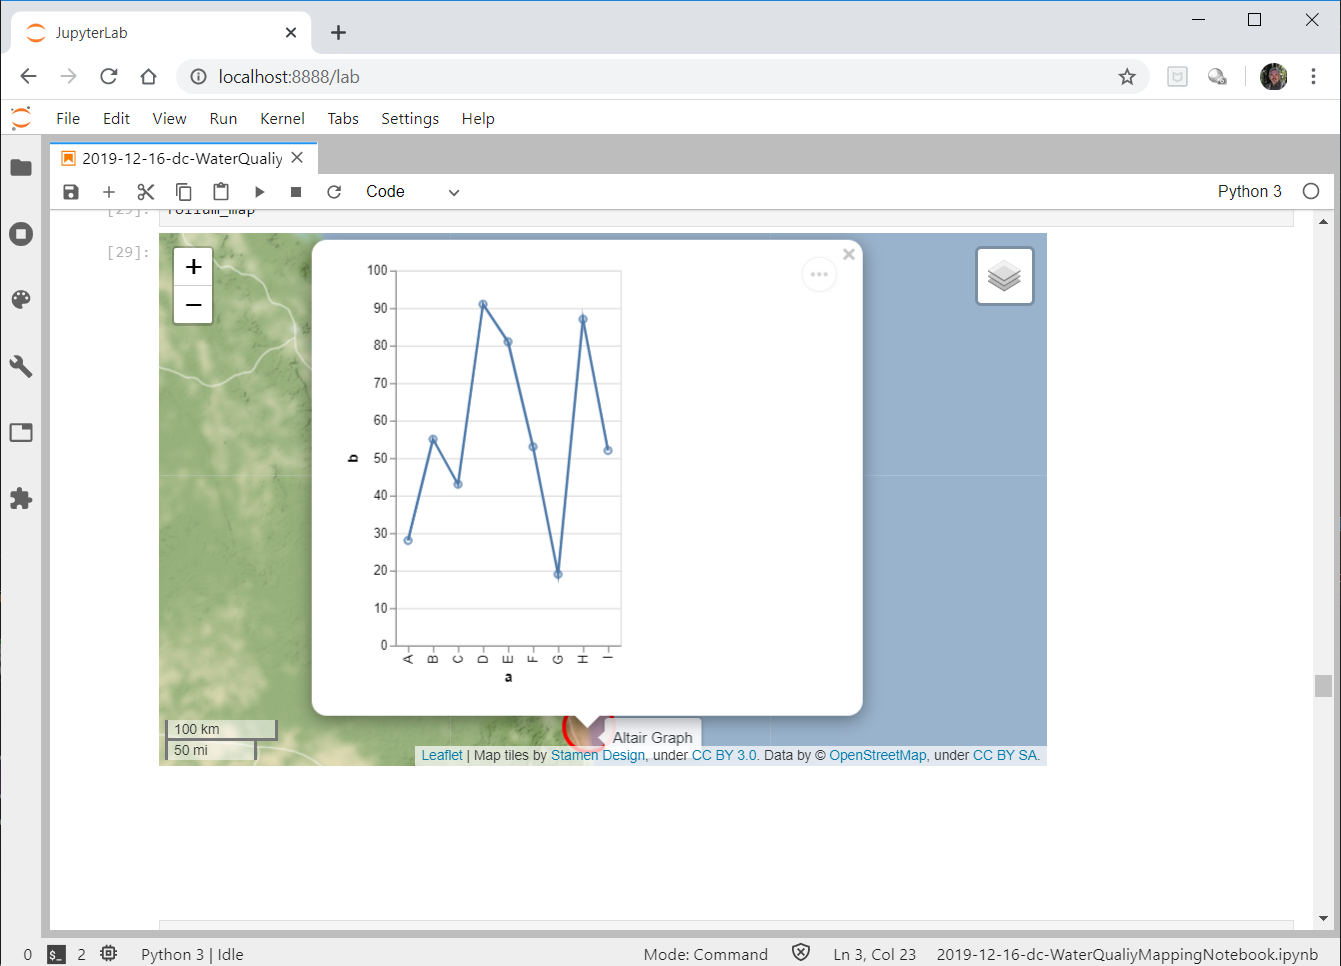

In [79]:
from IPython.display import Image

Image('../figures/folium03.png')

-------------
## Mapping plus Data Visualization

### Data Load

We load the spreadsheet of water quality measurements into pandas dataframe, and do the usual data exploration.

In [115]:
data_file = 'D:\\Water2019\\Final Water Monitoring Data April 2015 - Mar 2018 - Outliers Removed & Data Analysis.xlsx'

water_df = pd.read_excel(data_file)

In [33]:
water_df.head()

,Check,Site Code,Waterway,Subcatchment,Site Name,Waterbody Type,Sample Taker,Date Sample was Taken (dd-mm-yyyy),Time,Dissolved Oxygen (mg/L),...,Water Surface,Flow,Surface Slick,Offensive Odour,Floating Matter,Suspended Matter,Appearance,Dead Fauna,Water Level,Data Entry Note
0,Y-90,EUD575,Eudlo Creek,Eudlo Creek,Below Maroochydore Road at Montessori (near Eu...,Lowland Stream,Montessori Student,2015-06-09,09:45:00,16.20,...,C-Choppy,M-Medium,S-Slight,N-Nil,S-Slight,S-Slight,O-Opaque,P-Present,NaN,NaN
1,Y-90,PET160,Petrie Creek,Petrie Creek,"Jackson's Road Bridge, Hunchy (previously PET106)",Lowland Stream,Jenny Page,2015-07-27,17:00:00,11.85,...,F-Flat,S-Slow,N-Nil,N-Nil,N-Nil,N-Nil,C-Clean,P-Present,S-Stable,NaN
2,Done - Added Observation,PAY104,Paynter Creek,Paynter Creek,"Lower Landershute Rd, Palmwoods",Lowland Stream,Judy Venn,2015-10-05,14:50:00,10.95,...,F-Flat,N-Nil,S-Slight,N-Nil,S-Slight,S-Slight,C-Clean,N-Nil,F-Falling,NaN
3,Done - Added Observation,SMA700,South Maroochy River,South Maroochy,"Coleman's Farm Rd, Yandina",Lowland Stream,Cerran Fawns,2015-10-11,16:30:00,7.85,...,F-Flat,S-Slow,N-Nil,N-Nil,S-Slight,N-Nil,C-Clean,N-Nil,S-Stable,NaN
4,Done - Added Observation,PAY206,Paynter Creek,Paynter Creek,"Palmwoods-Montville Rd, Palmwoods",Lowland Stream,Stewart Medland,2015-10-15,09:00:00,10.24,...,C-Choppy,M-Medium,M-Moderate,N-Nil,S-Slight,S-Slight,M-Murky,N-Nil,R-Rising,NaN


Check that the waterway names match.

In [36]:
water_df['Waterway'].dropna().unique()

array(['Eudlo Creek', 'Petrie Creek', 'Paynter Creek',
       'South Maroochy River', 'North Maroochy River', 'Stumers Creek',
       'Martins Creek', 'Cornmeal Creek', 'Maroochy River',
       'Maroochy Estuary'], dtype=object)

Display the column names. 

In [37]:
water_df.columns

Index(['Check', 'Site Code', 'Waterway', 'Subcatchment', 'Site Name',
       'Waterbody Type', 'Sample Taker', 'Date Sample was Taken (dd-mm-yyyy)',
       'Time', 'Dissolved Oxygen (mg/L)', 'DO % (Calculated)', 'pH',
       'Turbidity (NTU)', 'Conductivity (mS/cm)', 'Water Temp (oC)',
       'Salinity (%)', 'Comments', 'Equipment Name & ID', 'Air Temperature',
       'Current Rainfall', 'Last Rainfall', 'Wind', 'Sky', 'Water Surface',
       'Flow', 'Surface Slick', 'Offensive Odour', 'Floating Matter',
       'Suspended Matter', 'Appearance', 'Dead Fauna', 'Water Level',
       'Data Entry Note'],
      dtype='object')

### Data Extract

We will display pH readings. First, check the datatypes of the columns of interest.  We see that the Date column is the correct data type.

In [41]:
water_df[
    ['Waterway', 'pH', 'Date Sample was Taken (dd-mm-yyyy)']
].dtypes

Waterway                                      object
pH                                           float64
Date Sample was Taken (dd-mm-yyyy)    datetime64[ns]
dtype: object

In [50]:
ph_df = (
    water_df[
        [
            'Site Code',
            'Waterway',
            'pH',
            'Date Sample was Taken (dd-mm-yyyy)',
        ]
    ]
    .dropna()
    .copy()
)

In [51]:
ph_df.head()

,Site Code,Waterway,pH,Date Sample was Taken (dd-mm-yyyy)
0,EUD575,Eudlo Creek,7.35,2015-06-09
1,PET160,Petrie Creek,8.43,2015-07-27
2,PAY104,Paynter Creek,5.40,2015-10-05
3,SMA700,South Maroochy River,8.52,2015-10-11
4,PAY206,Paynter Creek,4.20,2015-10-15


In [52]:
ph_df.tail()

,Site Code,Waterway,pH,Date Sample was Taken (dd-mm-yyyy)
1938,PAY206,Paynter Creek,6.70,2018-03-27
1939,NMA310,North Maroochy River,7.23,2018-03-29
1940,TUC140,Petrie Creek,7.45,2015-06-03
1941,TUC130,Petrie Creek,7.30,2015-06-03
1942,SMA346,South Maroochy River,7.79,2015-10-06


The column name of the Date column is a little unwieldly (especially for charting), so rename it.

In [59]:
ph_df.rename(
    columns={'Date Sample was Taken (dd-mm-yyyy)': 'Date'},
    inplace=True,
)
ph_df.head()

,Site Code,Waterway,pH,Date
0,EUD575,Eudlo Creek,7.35,2015-06-09
1,PET160,Petrie Creek,8.43,2015-07-27
2,PAY104,Paynter Creek,5.40,2015-10-05
3,SMA700,South Maroochy River,8.52,2015-10-11
4,PAY206,Paynter Creek,4.20,2015-10-15


Create a sample chart for a single site.

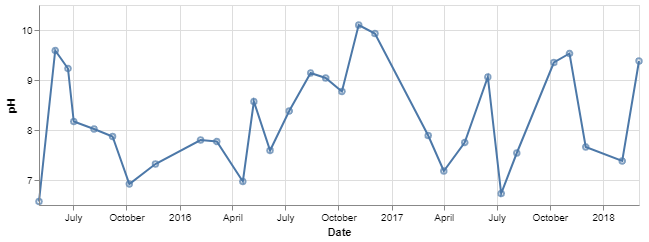

In [68]:
a = (
    alt.Chart(ph_df[ph_df['Site Code'] == 'STU100'])
    .mark_point()
    .encode(
        alt.X('Date'),
        alt.Y('pH:Q', scale=alt.Scale(zero=False)),
    )
    .properties(width=600, height=200)
)
b = (
    alt.Chart(ph_df[ph_df['Site Code'] == 'STU100'])
    .mark_line()
    .encode(
        alt.X('Date'),
        alt.Y('pH', scale=alt.Scale(zero=False)),
    )
    .properties(width=600, height=200)
)
a + b

### Helper Functions

#### make_ph_strip_chart 
creates an Altair Chart for the pH values at a given site

In [111]:
def make_ph_strip_chart(
    ph_df: pd.core.frame.DataFrame, site_code: str
) -> alt.Chart:
    '''
    make_ph_strip_chart: create Altair chart with point and lines overlay
    
    Notes:
    Altair default of always showing zero point on Y axis is overidden to reduce size
    site_code is added to title of chart
    
    '''

    WIDTH = 300
    HEIGHT = 100

    a = (
        alt.Chart(ph_df[ph_df['Site Code'] == site_code])
        .mark_point()
        .encode(
            alt.X('Date'),
            alt.Y('pH:Q', scale=alt.Scale(zero=False)),
        )
        .properties(
            width=WIDTH, height=HEIGHT, title=site_code
        )
    )
    b = (
        alt.Chart(ph_df[ph_df['Site Code'] == site_code])
        .mark_line()
        .encode(
            alt.X('Date'),
            alt.Y('pH', scale=alt.Scale(zero=False)),
        )
        .properties(
            width=WIDTH, height=HEIGHT, title=site_code
        )
    )
    return a + b


# end make_ph_strip_chart

#### add_site_strip_chart

Adds Folium markers with Altair Chart popups to a given map

In [112]:
def add_site_strip_chart(
    folium_map: folium.Map,
    cmap: matplotlib.colors.ListedColormap,
    site_df: pd.core.frame.DataFrame,
    ph_df: pd.core.frame.DataFrame,
    waterway_i: dict,
) -> None:
    '''
    add_site_markers: add markers for water quality sites to folium map
    
    Parameters:
    folium_map: folium.Map to add markers to
    cmap: colormap for waterway identification
    site_df: pandas dataframe hold water quality site locations
    waterway_i:  dictionary giving index into waterway names from waterway name
    
    Side Effects
    folium_map update with markers
    
    Return:
    site_fg: Folium Feature Group being added
   
    '''

    SITE_MARKER_SIZE = 5
    SITE_MARKER_FILL_OPACITY = 0.95

    WIDTH = 350
    HEIGHT = 100

    #  get arrays of data to be used to build markers
    lng = site_df['longitude']
    lat = site_df['latitude']

    site_code = site_df['Site Code']
    site_name = site_df['Site Name']

    waterway = site_df['Waterway']

    # create a FeatureGroup so Sites can be turned off
    site_fg = folium.FeatureGroup(
        name='Water Quality Sites', show=True
    )

    # for each  site, add marker to layer
    # marker is translucent so zoom out will look ok

    for (
        marker_y,
        marker_x,
        marker_site_code,
        marker_site_name,
        marker_way,
    ) in zip(lat, lng, site_code, site_name, waterway):

        # get R, G, B elements of color for this waterway
        # by looking up index of waterway from name
        # and using that index to get r,g,b from color map
        # alpha value ignored

        # get r, g. b, as 0.0<->1.0
        r, g, b, __ = cmap(waterway_i[marker_way])
        # get r, g, b as 0<->255
        r, g, b = (int(r * 256), int(g * 256), int(b * 256))

        # get Leaflet style color string (hex values for r, g, b)
        # two hex digits right justified, zero filled
        marker_color_string = f'#{r:0>2x}{g:0>2x}{b:0>2x}'

        # create strip chart
        chart = make_ph_strip_chart(ph_df, marker_site_code)
        vis1 = chart.to_json()

        circ_mkr = folium.CircleMarker(
            location=[marker_y, marker_x],
            radius=SITE_MARKER_SIZE,
            color=marker_color_string,
            fill=True,
            fill_color=marker_color_string,
            fillOpacity=SITE_MARKER_FILL_OPACITY,
            opacity=SITE_MARKER_FILL_OPACITY,
            tooltip=f'{marker_site_code}',
            popup=folium.Popup(
                max_width=WIDTH,
                sticky=True,  # sticky=True allows multiple popups to be open
            ).add_child(
                folium.VegaLite(
                    vis1, width=WIDTH, height=HEIGHT
                )
            ),
        )
        circ_mkr.add_to(site_fg)
    # end for

    # add unclustered markers to map
    site_fg.add_to(folium_map)

    return site_fg


# end add_site_strip_chart

#### Finally, the map

Having defined all our helper function, we create the map!

In [113]:
start_coords = [-26.52, 153.09]
folium_map = folium.Map(
    tiles=None,
    location=start_coords,
    zoom_start=13,
    width='80%',
    height='80%',
    control_scale=True,
)

# support two basemaps: Open Street Map will be the default
folium.TileLayer(
    tiles='OpenStreetMap', name='Open Street Map', show=True
).add_to(folium_map)
folium.TileLayer(
    tiles='Stamen Terrain', name='Terrain Map', show=False
).add_to(folium_map)


sites_fg = add_site_strip_chart(
    folium_map, cmap, site_df, ph_df, waterway_i
)
bounds = sites_fg.get_bounds()
folium_map.fit_bounds(bounds)

#  add a control to turn layers on / aff
folium.LayerControl().add_to(folium_map)

# add a title
title_html = '''
             <h3 align="left" style="font-size:20px"><b>ECOllaboration Water Quality Sites</b></h3>
             '''
folium_map.get_root().html.add_child(
    folium.Element(title_html)
)


display(folium_map)

The popup strip chart looks like:

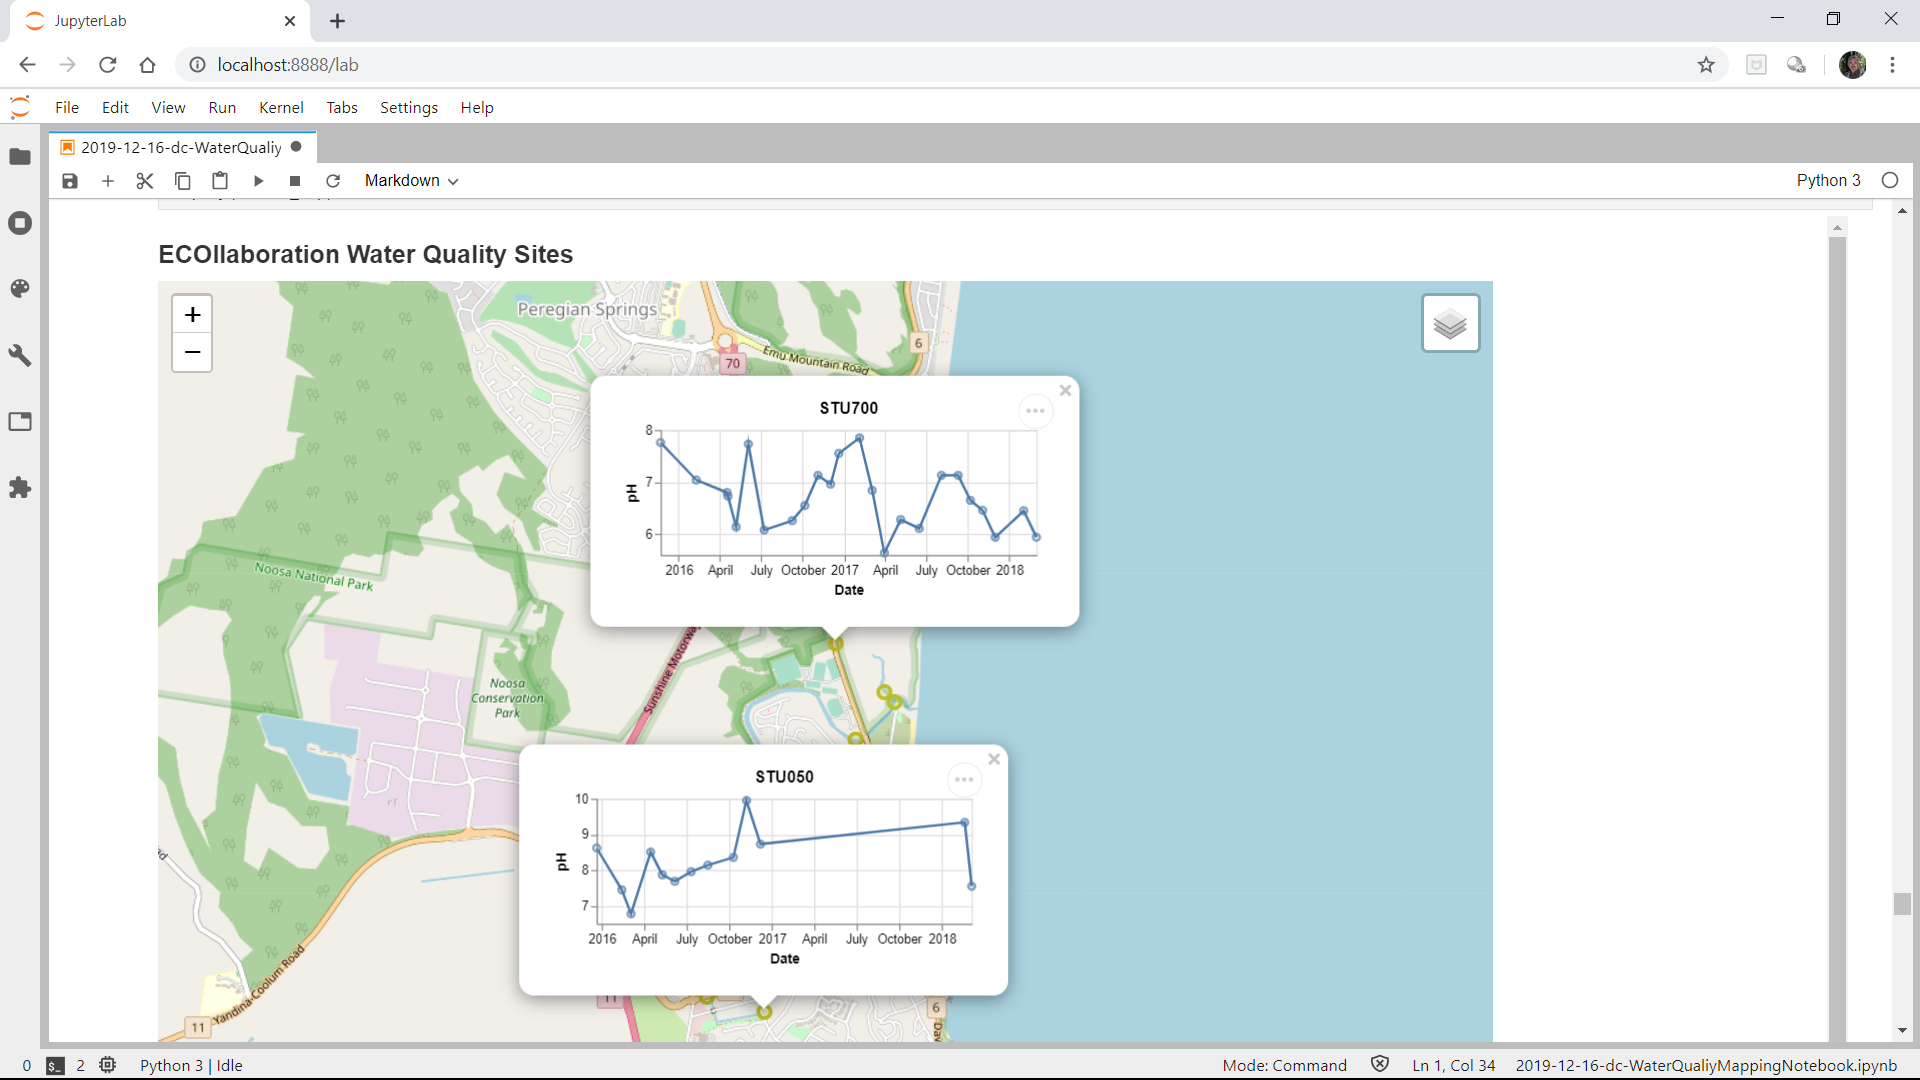

In [114]:
from IPython.display import Image

Image('../figures/folium05.png')

-----------------
## Conclusions / Summary

This is an example of how to tag markers in a Folium map with charts produced by Altair.  I remain to be convinced that this approach has general applicability, mainly because the map get cluttered very quickly with popups (I have chosen the ```sticky``` option).  Maybe if there was a facility to move the chart popups to a side panel ..., but now we talking about dashboard design :)  .

-------------------
## Reproducibility

### Notebook version status

In [116]:
theNotebook = (
    '2019-12-16-dc-WaterQualityMappingNotebook.ipynb'
)

In [117]:
# show info to support reproducibility


def python_env_name():
    envs = subprocess.check_output(
        'conda env list'
    ).splitlines()
    # get unicode version of binary subprocess output
    envu = [x.decode('ascii') for x in envs]
    active_env = list(
        filter(lambda s: '*' in str(s), envu)
    )[0]
    env_name = str(active_env).split()[0]
    return env_name


# end python_env_name

print('python version : ' + sys.version)
print('python environment :', python_env_name())
print('pandas version : ' + pd.__version__)

print('current wkg dir: ' + os.getcwd())
print('Notebook name: ' + theNotebook)
print(
    'Notebook run at: '
    + str(datetime.datetime.now())
    + ' local time'
)
print(
    'Notebook run at: '
    + str(datetime.datetime.utcnow())
    + ' UTC'
)
print('Notebook run on: ' + platform.platform())

python version : 3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]
python environment : ac5-py37
pandas version : 0.23.4
current wkg dir: C:\Users\donrc\Documents\JupyterNotebooks\WaterQualityMappingNotebookProject\develop
Notebook name: 2019-12-16-dc-WaterQualityMappingNotebook.ipynb
Notebook run at: 2019-12-22 19:37:18.873478 local time
Notebook run at: 2019-12-22 09:37:18.873478 UTC
Notebook run on: Windows-10-10.0.18362-SP0


In [118]:
%watermark

2019-12-22T19:37:38+10:00

CPython 3.7.1
IPython 7.2.0

compiler   : MSC v.1915 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [119]:
%watermark -h -iv

pandas     0.23.4
matplotlib 3.0.2
folium     0.10.0
platform   1.0.8
numpy      1.15.4
seaborn    0.9.0
altair     3.1.0
host name: DESKTOP-SODFUN6
